In [24]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [25]:
%%cython
cimport numpy as np
import numpy as np
import warnings
from numpy cimport ndarray, int64_t, float64_t, intp_t

ctypedef fused ordered:
    np.intp_t
    np.int32_t
    np.int64_t
    np.float32_t
    np.float64_t
    np.ndarray

from scipy.stats import multiscale_graphcorr


def classes(y):
    return(np.unique(y)).astype('int64')

def to_int_64(y):
    return (y.astype('int64'))

def mgc_stat(X,y):
    mgc = multiscale_graphcorr(X,y,reps = 0)
    return np.float64(mgc.stat)

def one_hot_y(unique_arr, matrices, sample_size):
    encode_view = []
    class_number = len(unique_arr)
    y_view_temp = np.zeros(shape=(sample_size, class_number), dtype = np.float64)
    temp = 0 
    temp_2 = 0 
    for k in range(class_number):
        n = matrices[k].shape[0]
        encode_view = np.zeros(shape=(n, class_number), dtype = np.float64)
        encode_view[:, k] = np.ones(shape=n, dtype = np.float64)
        temp_2 = temp + n
        y_view_temp[temp:temp_2,:] = encode_view
        temp = temp_2
    return y_view_temp
    
    

cpdef np.float64_t k_sample_test(float64_t [:, :] X_view , float64_t [:] y_view, str score_func = 'mgc'):
    """Nonparametric `K`-Sample Testing test statistic.
     
    A k-sample test tests equality in distribution among groups. Groups
    can be of different sizes, but must have the same dimensionality.
    This implementation reduces the k-sample testing to an 
    independence testing problem, and leverages notable and powerful
    multivariate independence tests.
    
    Read more in the :ref:`User Guide <multivariate_feature_selection>`.
    
    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
        Sample vectors.
    y : ndarray of shape (n_samples,)
        The target vector.
    score_func : string that refers to a multivariate independence test from scipy
        The default and only existing test is multiscale graph correlation.
    
    Returns
    -------
    stat : float that refers to the computed k-sample test statistic
    
    Notes
    -----
    1. The k-sample testing problem can be thought of as a generalization of
    the two sample testing problem. 
    
    2. By manipulating the inputs of the k-sample test, we create
    concatenated versions of the inputs and a label matrix which are
    paired. Then, any multivariate nonparametric test can be performed on
    this data.
    
    3. Multivariate feature selection uses k-sample test score function to
    calculate a test statistic for each feature not already selected as a 
    best feature. For each feature in that sub-section, inputted is a data matrix 
    with best features selected and that additional feature.
    
    References
    ----------
    .. [1] Sambit Panda, Cencheng Shen, Ronan Perry, Jelle Zorn, Antoine Lutz, 
           Carey E. Priebe, and Joshua T. Vogelstein. Nonpar MANOVA via 
           Independence Testing. arXiv:1910.08883 [cs, stat], April 2021. 

    """
    # extract data matrix of shape (_samples,_features) for each group

     # unsure if needs to be rewritten in cython
    cdef intp_t shape = len(X_view.shape)
    cdef int64_t [:] unique_view = classes(np.asarray(y_view))
    cdef int64_t [:] y_int_view = to_int_64(np.asarray(y_view))
    cdef list indices_view  = []
    cdef intp_t j 
    cdef intp_t i
    cdef list matrices = []
    cdef float64_t [:,:] xi_view
    cdef float64_t [:,:] X_copy_view = X_view.copy()
    cdef int64_t temp = 0
    cdef int64_t temp_2 = 0
    for j in range(len(unique_view)):
        indices_view = []        
        for i in range(len(y_int_view)):
            if y_int_view[i] == unique_view[j]:
                indices_view.append(i)
        if shape == 1:
            xi_view = X_view.base[indices_view]
        else:
            xi_view = X_view.base[indices_view,:]
        temp_2 = temp + xi_view.shape[0]
        X_copy_view.base[temp:temp_2, :] = xi_view
        temp = temp_2
        matrices.append(xi_view)
    X_view = X_copy_view
    # one hot encode y for multivariate independence test
    cdef int64_t sample_size = X_view.shape[0]
    cdef float64_t [:,:] y_final_view  = one_hot_y(unique_view,matrices,sample_size)
    cdef float64_t stat
    # default, which is mgc case
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        stat = mgc_stat(np.asarray(X_view),np.asarray(y_final_view))#unsure of cythonizing
    return stat

In [26]:
%%cython
cimport numpy as np
import numpy as np
import warnings
from numpy cimport ndarray, int64_t, float64_t, intp_t

ctypedef fused ordered:
    np.intp_t
    np.int32_t
    np.int64_t
    np.float32_t
    np.float64_t
    np.ndarray

from scipy.stats import multiscale_graphcorr


def sort(X):
    return(X[X[:, X.shape[1] - 1].argsort()]).astype('float64')

def zeros(sample_size,columns):
    return np.zeros(shape = (sample_size,columns), dtype = np.float64)

def ones(n):
    return np.ones(shape = n, dtype = np.float64)



def to_int_64(y):
    return (y.astype('int64'))

def mgc_stat(X,y):
    mgc = multiscale_graphcorr(X,y,reps = 0)
    return np.float64(mgc.stat)

cpdef float64_t[:,:] one_hot_y(list startpoints, int64_t sample_size):
    cdef int64_t class_number = len(startpoints) + 1
    cdef float64_t[:,:] y_view_temp = zeros(sample_size, class_number)
    cdef int64_t k 
    for k in range(class_number):
        if k == 0:
            y_view_temp.base[0:startpoints[k],k] = ones(startpoints[k])
        elif k != 0 and k != class_number - 1:
            y_view_temp.base[startpoints[k-1]:startpoints[k],k] = ones(startpoints[k] - startpoints[k-1])
        else:
            y_view_temp.base[startpoints[k-1]:,k] = ones(sample_size - startpoints[k-1])
    return y_view_temp
    
    

cpdef np.float64_t k_sample_test_2(float64_t [:, :] X_view , float64_t [:] y_view, str score_func = 'mgc'):
    """Nonparametric `K`-Sample Testing test statistic.
     
    A k-sample test tests equality in distribution among groups. Groups
    can be of different sizes, but must have the same dimensionality.
    This implementation reduces the k-sample testing to an 
    independence testing problem, and leverages notable and powerful
    multivariate independence tests.
    
    Read more in the :ref:`User Guide <multivariate_feature_selection>`.
    
    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
        Sample vectors.
    y : ndarray of shape (n_samples,)
        The target vector.
    score_func : string that refers to a multivariate independence test from scipy
        The default and only existing test is multiscale graph correlation.
    
    Returns
    -------
    stat : float that refers to the computed k-sample test statistic
    
    Notes
    -----
    1. The k-sample testing problem can be thought of as a generalization of
    the two sample testing problem. 
    
    2. By manipulating the inputs of the k-sample test, we create
    concatenated versions of the inputs and a label matrix which are
    paired. Then, any multivariate nonparametric test can be performed on
    this data.
    
    3. Multivariate feature selection uses k-sample test score function to
    calculate a test statistic for each feature not already selected as a 
    best feature. For each feature in that sub-section, inputted is a data matrix 
    with best features selected and that additional feature.
    
    References
    ----------
    .. [1] Sambit Panda, Cencheng Shen, Ronan Perry, Jelle Zorn, Antoine Lutz, 
           Carey E. Priebe, and Joshua T. Vogelstein. Nonpar MANOVA via 
           Independence Testing. arXiv:1910.08883 [cs, stat], April 2021. 

    """
    # extract data matrix of shape (_samples,_features) for each group

     # unsure if needs to be rewritten in cython
    cdef intp_t shape = len(X_view.shape)
    cdef int64_t sample_size = X_view.shape[0]
    cdef float64_t [:,:] X_y = zeros(sample_size,X_view.shape[1] + 1)
    X_y.base[:,0:X_view.shape[1]] = X_view.copy()
    X_y.base[:,X_y.shape[1] - 1] = y_view.copy()
    X_y = sort(np.asarray(X_y))
    cdef int64_t [:] y_int_view = to_int_64(np.asarray(X_y.base[:,X_y.shape[1] - 1]))
    cdef intp_t i
    cdef int64_t temp
    cdef list startpoints = []
    cdef int64_t counter = 0
    for i in y_int_view:
        if counter != 0:
            if i != temp:
                startpoints.append(counter)
        temp = i
        counter = counter + 1
    X_view = X_y.base[:,0:X_view.shape[1]]
    cdef float64_t [:,:] y_final_view  = one_hot_y(startpoints,sample_size)
    cdef float64_t stat
    # default, which is mgc case
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        stat = mgc_stat(np.asarray(X_view),np.asarray(y_final_view))#unsure of cythonizing
    return stat

In [29]:
from sklearn.base import BaseEstimator
from sklearn.feature_selection import SelectorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
import numpy as np
from scipy.stats import multiscale_graphcorr
from scipy._lib._util import MapWrapper
import warnings

def k_sample(X, y,score_func="mgc"):
    """Compute the multivariate independence test statisitic for the provided sample.
    Read more in the :ref:`User Guide <multivariate_feature_selection>`.
    Parameters
    ----------
    X : {array-like, sparse matrix} of shape (n_samples, n_features)
        The set of regressors that will be tested sequentially.
    y : ndarray of shape (n_samples,)
        The target vector.
    score_func : string that refers to a k_sample multivariate independence test from scipy
                The default and only existing test is multiscale graph correlation.
    Returns
    -------
    stat : float that refers to the computed k_sample test statistic
    """
    k_array = np.unique(y)
    matrices = []
    for i in k_array:
        indices = np.where(y == i)[0] 
        if len(X.shape) == 1:
            xi = X[indices]
        else:
            xi = X[indices,:]
        matrices.append(xi)
    X = np.concatenate(matrices)
    vs = []
    for i in range(len(np.unique(y))):
        n = matrices[i].shape[0]
        encode = np.zeros(shape=(n, len(matrices)))
        encode[:, i] = np.ones(shape=n)
        vs.append(encode)
    y = np.concatenate(vs) #mgc case
    return(X,y)

def multiscale_graph_corr(X,y):    
    warnings.filterwarnings("ignore")
    mgc = multiscale_graphcorr(X,y,reps = 0)
    stat = mgc.stat
    return stat

In [30]:
from sklearn.base import BaseEstimator
from sklearn.feature_selection import SelectorMixin
import numpy as np
from scipy.stats import multiscale_graphcorr
from scipy.sparse import isspmatrix
import warnings
from sklearn.utils.validation import check_is_fitted
from joblib import Parallel, delayed

######################################################################
# Scoring function

# The following is a rewriting of hyppo.ksample.KSample
# from hyppo.neurodata.io
def k_sample_test_original(X, y,score_func="mgc"):
    """Nonparametric `K`-Sample Testing test statistic.
     
    A k-sample test tests equality in distribution among groups. Groups
    can be of different sizes, but must have the same dimensionality.
    This implementation reduces the k-sample testing to an 
    independence testing problem, and leverages notable and powerful
    multivariate independence tests.
    
    Read more in the :ref:`User Guide <multivariate_feature_selection>`.
    
    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
        Sample vectors.
    y : ndarray of shape (n_samples,)
        The target vector.
    score_func : string that refers to a multivariate independence test from scipy
        The default and only existing test is multiscale graph correlation.
    
    Returns
    -------
    stat : float that refers to the computed k-sample test statistic
    
    Notes
    -----
    1. The k-sample testing problem can be thought of as a generalization of
    the two sample testing problem. 
    
    2. By manipulating the inputs of the k-sample test, we create
    concatenated versions of the inputs and a label matrix which are
    paired. Then, any multivariate nonparametric test can be performed on
    this data.
    
    3. Multivariate feature selection uses k-sample test score function to
    calculate a test statistic for each feature not already selected as a 
    best feature. For each feature in that sub-section, inputted is a data matrix 
    with best features selected and that additional feature.
    
    References
    ----------
    .. [1] Sambit Panda, Cencheng Shen, Ronan Perry, Jelle Zorn, Antoine Lutz, 
           Carey E. Priebe, and Joshua T. Vogelstein. Nonpar MANOVA via 
           Independence Testing. arXiv:1910.08883 [cs, stat], April 2021. 

    """
    # extract data matrix of shape (_samples,_features) for each group
    k_array = np.unique(y)
    matrices = []
    for i in k_array:
        indices = np.where(y == i)[0] 
        if len(X.shape) == 1:
            xi = X[indices]
        else:
            xi = X[indices,:]
        matrices.append(xi)
    X = np.concatenate(matrices)
    # one hot encode y for multivariate independence test
    vs = []
    for i in range(len(np.unique(y))):
        n = matrices[i].shape[0]
        encode = np.zeros(shape=(n, len(matrices)))
        encode[:, i] = np.ones(shape=n)
        vs.append(encode)
    y = np.concatenate(vs)
    
    # default, which is mgc case
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        mgc = multiscale_graphcorr(X,y,reps = 0)
    stat = mgc.stat 
    return stat

In [13]:

from sklearn.datasets import make_classification

func1_time = []
for j in[100,200,500,1000]:
    for i in [2,5,10,20]:
        X, y = make_classification(
            n_samples=j,
            n_features=i,
            n_informative=i-1,
            n_redundant=0,
            n_repeated=0,
            n_classes=2,
            n_clusters_per_class=1,
            flip_y=0.0,
            class_sep=4,
            shuffle=False,
            random_state=0,
        )
        foo =  %timeit -o k_sample_test(X.astype('float64'),y.astype('float64'))
        func1_time.append(foo)
print(func1_time)

5.13 ms ± 252 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.35 ms ± 404 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.1 ms ± 18.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.17 ms ± 18.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
11.9 ms ± 89 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
12.2 ms ± 336 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
12.1 ms ± 173 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
12.6 ms ± 65.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
53.7 ms ± 1.69 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
53.7 ms ± 1.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
56.1 ms ± 537 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
58 ms ± 261 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
288 ms ± 2.25 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
294 ms ± 2.16 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
306 ms ± 3.14 ms

In [15]:
func1_time = []
for j in[100,200,500,1000]:
    for i in [2,5,10,20]:
        X, y = make_classification(
            n_samples=j,
            n_features=i,
            n_informative=i-1,
            n_redundant=0,
            n_repeated=0,
            n_classes=2,
            n_clusters_per_class=1,
            flip_y=0.0,
            class_sep=4,
            shuffle=False,
            random_state=0,
        )
        foo =  %timeit -o k_sample_test_2(X.astype('float64'),y.astype('float64'))
        func1_time.append(foo)
print(func1_time)

5.38 ms ± 394 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.19 ms ± 194 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.55 ms ± 453 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.9 ms ± 412 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
13.7 ms ± 294 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
12.7 ms ± 748 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
12.2 ms ± 77.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
12.7 ms ± 335 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
53.6 ms ± 1.93 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
54.4 ms ± 1.57 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
52.7 ms ± 803 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
58 ms ± 545 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
291 ms ± 4.88 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
296 ms ± 4.78 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
302 ms ± 2 ms pe

In [32]:
from sklearn.datasets import make_classification
func1_time = []
for j in[100,200,500,1000]:
    for i in [100,200,500,1000]:
        X, y = make_classification(
            n_samples=j,
            n_features=i,
            n_informative=10,
            n_redundant=0,
            n_repeated=0,
            n_classes=2,
            n_clusters_per_class=1,
            flip_y=0.0,
            class_sep=4,
            shuffle=False,
            random_state=0,
        )
        %timeit -o k_sample_test(X.astype('float64'),y.astype('float64'))
        %timeit -o k_sample_test_2(X.astype('float64'),y.astype('float64'))
        %timeit -o k_sample_test_original(X.astype('float64'),y.astype('float64'))
        %timeit -o k_sample(X,y)
        %timeit -o multiscale_graph_corr(X,y)
        

6.35 ms ± 452 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.98 ms ± 31.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
6.17 ms ± 448 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
45.9 µs ± 279 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
5.91 ms ± 113 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
7.25 ms ± 37.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
7.23 ms ± 22.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
7.34 ms ± 116 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
58.6 µs ± 298 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
7 ms ± 25.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
10.9 ms ± 67.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
10.9 ms ± 17.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
10.8 ms ± 27.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
82.2 µs ± 4.82 µs per loop (mean ± std. dev. of 7 runs, 10000 loops e

In [14]:
from sklearn.datasets import make_classification
for j in[100,200,500,1000]:
    for i in [100,200,500,1000]:
        X, y = make_classification(
            n_samples=j,
            n_features=i,
            n_informative=10,
            n_redundant=5,
            n_repeated=0,
            n_classes=4,
            n_clusters_per_class=3,
            flip_y=0.0,
            class_sep=4,
            shuffle=False,
            random_state=0,
        )
        foo =  %timeit -o k_sample_test_2(X.astype('float64'),y.astype('float64'))
        func1_time.append(foo)

6.3 ms ± 348 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
8.55 ms ± 1.32 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
11.1 ms ± 155 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
16.9 ms ± 79.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
15.8 ms ± 140 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
20.3 ms ± 159 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
35 ms ± 203 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
58.5 ms ± 354 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
78.5 ms ± 800 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
117 ms ± 5.94 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
218 ms ± 9.62 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
365 ms ± 16 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
401 ms ± 1.27 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
515 ms ± 1.33 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
916 ms ± 32.8 ms per loop 

In [11]:
for j in[100,200,500,1000]:
    for i in [100,200,500,1000]:
        X, y = make_classification(
            n_samples=j,
            n_features=i,
            n_informative=10,
            n_redundant=5,
            n_repeated=0,
            n_classes=4,
            n_clusters_per_class=3,
            flip_y=0.0,
            class_sep=4,
            shuffle=False,
            random_state=0,
        )
        %timeit -o k_sample_test_3(X.astype('float64'),y.astype('float64'))

6.44 ms ± 235 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
7.53 ms ± 393 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
12.1 ms ± 630 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
20.9 ms ± 2.38 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
16.8 ms ± 863 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
20.4 ms ± 208 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
35.5 ms ± 537 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
59.2 ms ± 841 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
81.3 ms ± 4.71 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
111 ms ± 3.36 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
206 ms ± 12.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
378 ms ± 15.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
448 ms ± 28.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
563 ms ± 21.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
930 ms ± 33.9 ms per l

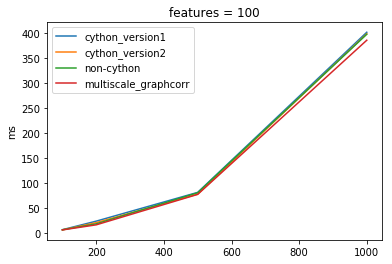

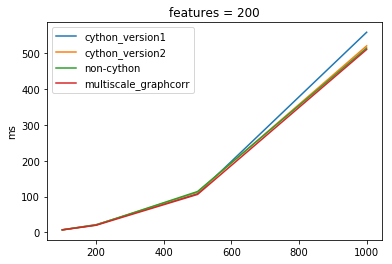

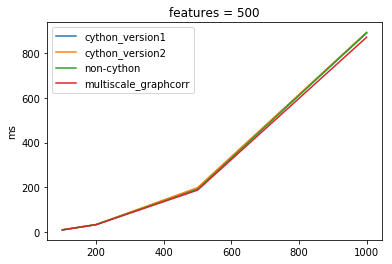

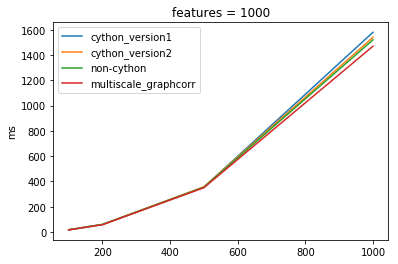

In [34]:
import matplotlib.pyplot as plt
plt.plot([100,200,500,1000],[6.35,23.5,81.1,402], label = 'cython_version1')
plt.plot([100,200,500,1000],[5.98,20.5,77.6,399], label = 'cython_version2')
plt.plot([100,200,500,1000],[6.17,18.1,80.4,398], label = 'non-cython')
plt.plot([100,200,500,1000],[5.91,16.1,77.1,386], label = 'multiscale_graphcorr')
plt.title('features = 100')
plt.ylabel('ms')
plt.legend()
plt.show()
plt.plot([100,200,500,1000],[7.25,21.6,108,558], label = 'cython_version1')
plt.plot([100,200,500,1000],[7.23,21.1,112,520], label = 'cython_version2')
plt.plot([100,200,500,1000],[7.34,20.6,114,514], label = 'non-cython')
plt.plot([100,200,500,1000],[7,20,106,510], label = 'multiscale_graphcorr')
plt.title('features = 200')
plt.ylabel('ms')
plt.legend()
plt.show()
plt.plot([100,200,500,1000],[10.9,34.5,196,889], label = 'cython_version1')
plt.plot([100,200,500,1000],[10.8,34.3,199,892], label = 'cython_version2')
plt.plot([100,200,500,1000],[10.8,34.5,191,890], label = 'non-cython')
plt.plot([100,200,500,1000],[10.6,33.8,188,870], label = 'multiscale_graphcorr')
plt.title('features = 500')
plt.ylabel('ms')
plt.legend()
plt.show()
plt.plot([100,200,500,1000],[17.1,59.4,354,1580], label = 'cython_version1')
plt.plot([100,200,500,1000],[17.1,59.2,357,1540], label = 'cython_version2')
plt.plot([100,200,500,1000],[16.9,58.9,354,1520], label = 'non-cython')
plt.plot([100,200,500,1000],[16,57.3,350,1470], label = 'multiscale_graphcorr')
plt.title('features = 1000')
plt.ylabel('ms')
plt.legend()
plt.show()